In [15]:
import os
import sys
import random
import cv2
import math
import time
import numpy as np
import re
import glob
import pandas as pd

ROOT_DIR = os.path.abspath('../models/Mask_RCNN')
DATA_DIR = '../data'
#import mask rcnn
sys.path.append(ROOT_DIR)

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn.model import log

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [2]:
from sklearn import model_selection

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from mrcnn import visualize
import scipy.misc

%matplotlib inline 

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [16]:
class SegmentationConfig(Config):
  NAME = "SegmentationConfig"
  IMAGES_PER_GPU = 2
  NUM_CLASSES = 1 + 9 # background + 9
  STEPS_PER_EPOCH = 1000 #1000

class SegmentationDataset(utils.Dataset):
  ALL_CLASSES = [
              ('bicycle', 35),
              ('bicycle_group', 163),
              ('billboard', 86),
              ('bridge', 98),
              ('building', 97),
              ('bus', 39),
              ('bus_group', 167),
              ('car', 33),
              ('car_groups', 161),
              ('dustbin', 85),
              ('fence', 67),
              ('motorbicycle', 34),
              ('motorbicycle_group', 162),
              ('others', 0),
              ('overpass', 100),
              ('person', 36),
              ('person_group', 164),
              ('pole', 82),
              ('rider', 37),
              ('rider_group', 165),
              ('road', 49),
              ('road_pile', 66),
              ('rover', 1),
              ('siderwalk', 50),
              ('sky', 17),
              ('traffic_cone', 65),
              ('traffic_light', 81),
              ('traffic_sign', 83),
              ('tricycle', 40),
              ('tricycle_group', 168),
              ('truck', 38),
              ('truck_group', 166),
              ('tunnel', 99),
              ('vegatation', 113),
              ('wall', 84)
            ]

  MAIN_CLASSES = [33, 35, 39, 40, 36, 65, 34, 38, 37]

  CLASSES = [ c for c in ALL_CLASSES if c[1] in [33, 35, 39, 40, 36, 65, 34, 38, 37] ]
  CLASS_NAME_TO_ID = {}
  CLASS_ID_TO_NAME = {}
  CLASS_OLD_ID_TO_ID = {}
  for i in range( len(CLASSES) ):
      c_name = CLASSES[i][0]
      old_id = CLASSES[i][1]
      new_id = i + 1

      CLASS_NAME_TO_ID[c_name] = { 'id': new_id,   'old_id': old_id }
      CLASS_ID_TO_NAME[new_id] = { 'name': c_name, 'old_id': old_id }
      CLASS_OLD_ID_TO_ID[old_id] = { 'name': c_name, 'id': new_id }

  def load_cvpr_images(self, images_paths):
    # Add classes
    for class_name in self.CLASS_NAME_TO_ID.keys():
      self.add_class("wad", self.CLASS_NAME_TO_ID[class_name]['id'], class_name)

    for i in range(len(images_paths)):
      path = images_paths[i]
      image_name = path.split('/')[-1].split('.')[0]
      self.add_image("wad", image_id=i, path=path, image_name=image_name)

  def load_mask(self, image_id):
    image_name = self.image_info[image_id]['image_name']
    path = DATA_DIR+"/train_label/"+ image_name +"_instanceIds.png"
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    ids = []

    all_instances = np.unique(image)
    intances_ids = [ int(x/1000) for x in all_instances ]
    intances_ids = np.array([x for x in intances_ids if x in self.MAIN_CLASSES ])

    masks_shape = (image.shape[0], image.shape[1], intances_ids.shape[0])
    masks = np.zeros(masks_shape, dtype=np.bool)

    i_ = 0
    for i in range(all_instances.shape[0]):
      class_id = int(all_instances[i]/1000)
      if self.CLASS_OLD_ID_TO_ID.get(class_id):
        ids.append(self.CLASS_OLD_ID_TO_ID[class_id]['id'])
        masks[:, :, i_] = (image == all_instances[i])
        i_+=1

    ids = np.array(ids, dtype=np.int32)
    return masks, ids


In [17]:
train = glob.glob(DATA_DIR+'/train_color/*.jpg')
test = glob.glob(DATA_DIR+'/test/*.jpg')
X_train, X_val, _, _ = model_selection.train_test_split(train, train, test_size=0.3)
config = SegmentationConfig()
config.display()
dataset_train = SegmentationDataset()
dataset_train.load_cvpr_images(X_train)
dataset_train.prepare()

dataset_val = SegmentationDataset()
dataset_val.load_cvpr_images(X_val)
dataset_val.prepare()

testset = SegmentationDataset()
testset.load_cvpr_images(test)
testset.prepare()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

In [18]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [9]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=15, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/labs/cvpr/models/Mask_RCNN/logs/segmentationconfig20180530T2312/mask_rcnn_segmentationconfig_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mas

### Inference

In [19]:
class InferenceConfig(SegmentationConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/ram/Documents/moises/proyectos/labs/ml/mix/cvpr_2018_segmentation_wad/models/Mask_RCNN/logs/segmentationconfig20180530T2312/mask_rcnn_segmentationconfig_0015.h5


In [20]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (22,)                 min:    0.00000  max: 8954.00000  float64
gt_class_id              shape: (7,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (7, 4)                min:    5.00000  max:  664.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  bool


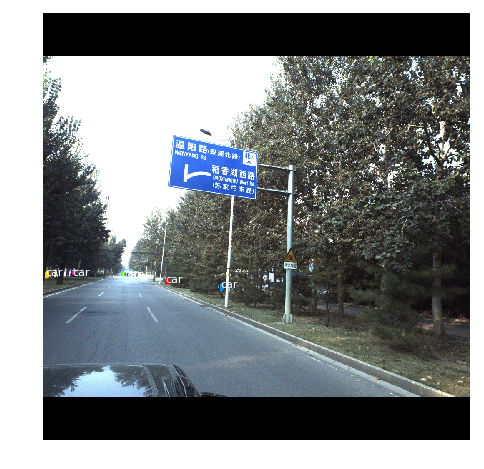

In [21]:
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

### Predict

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


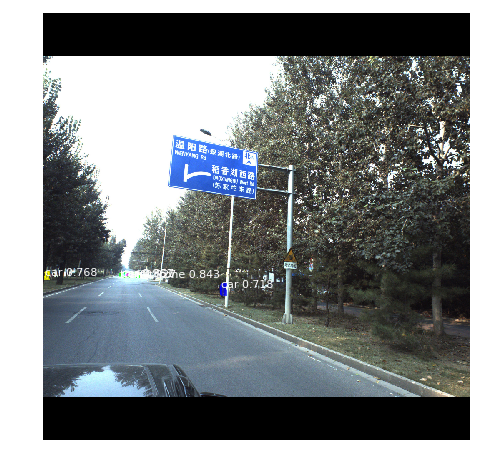

In [22]:
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [19]:
r['rois']

array([[ 652,  226,  745,  377],
       [ 711,  763,  883, 1020],
       [ 647,    0,  748,  154],
       [ 664,  644,  751,  765],
       [ 626,  587,  696,  662],
       [ 627,  500,  644,  518],
       [ 634,  219,  669,  295],
       [ 639,  747,  666,  756],
       [ 671,  986,  720, 1005],
       [ 637,  568,  680,  591],
       [ 638,  755,  664,  763],
       [ 641,  766,  664,  776],
       [ 628,  361,  645,  381],
       [ 667, 1002,  726, 1022],
       [ 639,  761,  663,  770],
       [ 627,  467,  637,  484],
       [ 640,  683,  663,  692],
       [ 639,  790,  663,  799],
       [ 610,   13,  641,   26],
       [ 641,  771,  663,  780]], dtype=int32)

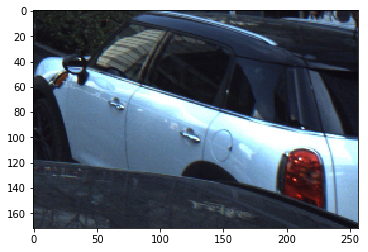

In [33]:
plt.imshow(original_image[711:883,763:1020, :])

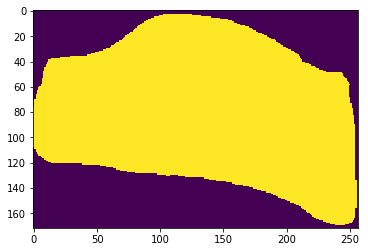

In [42]:
plt.imshow(r['masks'][:, :, 1][711:883,763:1020])

In [13]:
len(testset.image_ids)

1917

### Getting the test data results

In [148]:
from skimage.io import imsave
from multiprocessing import Pool
pool = Pool(processes=8)


In [149]:
def process_result(r, image_name, image_id):
    data = []
    for i in range(len(r['scores'])):
        mask_idx = i
        confidence = r['scores'][i]
        label_id = r['class_ids'][i]
        mask = r['masks'][:, :, i]
        rois = r['rois'][i]

        data_point = {}
        old_id = testset.CLASS_ID_TO_NAME[label_id]['old_id']
        mask_name = DATA_DIR+'/test_masks/'+ image_name + '_' + str(mask_idx) +'.jpg'
        imsave(mask_name, mask)

        data_point['ImageId'] = image_name
        data_point['LabelId'] = old_id
        data_point['Confidence'] = confidence
        data_point['PixelCount'] = 0
        data_point['rois'] = rois
        data_point['EncodedPixels'] = mask_name

        data.append(data_point)

    return data

In [153]:
test_results = []
jobs = []
t3 = time.time()
for test_id in testset.image_ids:
    if (test_id % 50) == 0:
        print(test_id)
    results = model.detect([testset.load_image(test_id)], verbose=0)
    r = results[0]

    image_name = testset.image_info[test_id]['image_name']

    p_result = pool.apply_async(process_result, (r, image_name, test_id) )
    jobs.append(p_result)

for job in jobs:
    p_result = job.get(timeout=20)
    test_results = test_results + p_result
t3_ = time.time()
print("Time for all takes:", t3_ - t3)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
Time for all takes: 1903.5072393417358


In [154]:
print(len(test_results) )
test_results[-1]

20328


{'Confidence': 0.7283339,
 'EncodedPixels': '/home/ubuntu/datalab/test_masks/85a05af396157acd1ecfa10a8e6d70b1_7.jpg',
 'ImageId': '85a05af396157acd1ecfa10a8e6d70b1',
 'LabelId': 33,
 'PixelCount': 0,
 'rois': array([1743,  501, 1873,  662], dtype=int32)}

In [157]:
# df_test_results = pd.DataFrame(test_results)

In [24]:
df_test_results = pd.read_csv(DATA_DIR+'/test_results.csv')
df_test_results.head()

,ImageId,LabelId,Confidence,PixelCount,EncodedPixels,rois
0,56dbd8514bd2b8d1566f8977cfeb0406,33,0.999186,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1911 2476 2425 3219]
1,56dbd8514bd2b8d1566f8977cfeb0406,33,0.998902,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1773 2146 1861 2412]
2,56dbd8514bd2b8d1566f8977cfeb0406,33,0.998630,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1783 2775 1850 2903]
3,56dbd8514bd2b8d1566f8977cfeb0406,33,0.998304,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1791 2936 1881 3078]
4,56dbd8514bd2b8d1566f8977cfeb0406,33,0.993302,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1679 6 1755 197]


In [25]:
columns = ['ImageId','LabelId','PixelCount','Confidence','EncodedPixels']

['ImageId', 'LabelId', 'PixelCount', 'Confidence', 'EncodedPixels']

In [160]:
df_test_results.to_csv(DATA_DIR+'/submit_test_.csv',index=False, columns=columns)

In [152]:
a=cv2.imread(DATA_DIR+'/test_masks/4e3c95fe41cce1072ccbb69e8a1a20fb_4.jpg')

In [141]:
a.sum()

167448

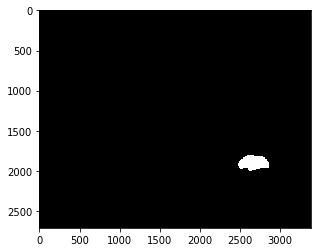

In [142]:
plt.imshow(a*255)

In [94]:
r['masks'][:, :, 0].shape

(2710, 3384)

In [15]:

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.29489026500925447


In [74]:
r["rois"]

array([[ 711,  422,  928,  894],
       [ 685,  826,  748, 1004],
       [ 629,  222,  648,  243],
       [ 647,  507,  679,  569],
       [ 641,  447,  656,  474],
       [ 645,  501,  670,  530],
       [ 643,  503,  654,  530],
       [ 641,  482,  660,  499]], dtype=int32)

In [75]:
r["class_ids"]

array([3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [76]:
r["scores"]

array([0.9969446 , 0.9946017 , 0.992332  , 0.83706295, 0.8179433 ,
       0.81449354, 0.7057352 , 0.7026884 ], dtype=float32)

In [16]:
r

{'class_ids': array([3, 3, 3, 9, 3, 3, 3, 9, 3, 3, 3, 3], dtype=int32),
 'masks': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
 

#### Submision File


In [42]:
d = df_test_results.ix[55]


ImageId                           c08594b8bfe42348b0fe056136492596
LabelId                                                         33
Confidence                                                0.999855
PixelCount                                                       0
EncodedPixels    /home/ubuntu/datalab/test_masks/c08594b8bfe423...
rois                                         [1744 1446 1842 1559]
Name: 55, dtype: object

In [53]:
mask_path = d['EncodedPixels'].split('/')[-1]
mask_im = cv2.imread(DATA_DIR+'/test_masks/'+mask_path, cv2.IMREAD_UNCHANGED)

In [70]:
mask_bound = [ int(x) for x in d.rois.replace("[", "").replace("]", "").split() ]
mask = mask_im[mask_bound[0]:mask_bound[2], mask_bound[1]:mask_bound[3]]

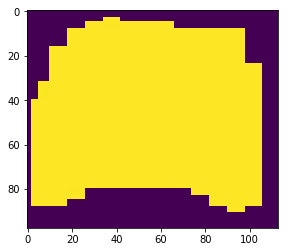

In [84]:
plt.imshow(mask*255)

In [128]:
def find_pixels(mask):
    endcoded_pixels = []
    total_pixels = 0
    for i in range(mask.shape[0]):
        init = 0
        end = 0
        carry = i*mask.shape[1]
        for j in range(1, mask.shape[1]):
            if mask[i, j] > 0 and mask[i, j - 1] == 0:
                init = j + carry

            if mask[i, j] == 0 and mask[i, j - 1] > 0:
                end = j-init + carry
                endcoded_pixels.append( str(init) + ' ' +  str(end) ) 
                total_pixels += end
                init = 0
                end = 0

    return endcoded_pixels, total_pixels

In [135]:
encodp, _ = find_pixels(mask)

In [138]:
"|".join(encodp) + "|"

'373 8|486 8|591 40|704 40|817 40|922 80|1035 80|1148 80|1261 80|1374 80|1487 80|1600 80|1713 80|1818 88|1931 88|2044 88|2157 88|2270 88|2383 88|2496 88|2609 88|2722 96|2835 96|2948 96|3061 96|3174 96|3287 96|3400 96|3513 96|3621 101|3734 101|3847 101|3960 101|4073 101|4186 101|4299 101|4412 101|4522 104|4635 104|4748 104|4861 104|4974 104|5087 104|5200 104|5313 104|5426 104|5539 104|5652 104|5765 104|5878 104|5991 104|6104 104|6217 104|6330 104|6443 104|6556 104|6669 104|6782 104|6895 104|7008 104|7121 104|7234 104|7347 104|7460 104|7573 104|7686 104|7799 104|7912 104|8025 104|8138 104|8251 104|8364 104|8477 104|8590 104|8703 104|8816 104|8929 104|9042 24|9114 32|9155 24|9227 32|9268 24|9340 32|9381 24|9461 24|9494 24|9574 24|9607 16|9687 24|9720 16|9800 24|9833 16|9913 24|10034 8|10147 8|10260 8|'

In [145]:
df_test_results['PixelCount'][3]

4

In [ ]:
for i in range(df_test_results.shape[0]):
    d = df_test_results.ix[i]
    mask_path = d['EncodedPixels'].split('/')[-1]
    mask_im = cv2.imread(DATA_DIR+'/test_masks/'+mask_path, cv2.IMREAD_UNCHANGED)
    mask_bound = [ int(x) for x in d.rois.replace("[", "").replace("]", "").split() ]
    mask = mask_im[mask_bound[0]:mask_bound[2], mask_bound[1]:mask_bound[3]]
    encoded_pixels, pixels_count = find_pixels(mask)
    encoded_pixels = "|".join(encoded_pixels) + "|"
    df_test_results['PixelCount'][i] = pixels_count
    df_test_results['EncodedPixels'][i] = encoded_pixels

(98, 113)